# 🌟 **Sentiment Analysis on Yelp Reviews**

Welcome to my in-depth sentiment analysis notebook! 🚀

In this notebook, I embark on a journey to understand sentiments from text reviews using state-of-the-art machine learning techniques. My goal is to transform raw text into insightful sentiment predictions (Positve or Negative).

## 👤 **Author Information**

- **Name**: Angelo Traverso
- **Module Code**: PDAN8412
- **Due Date**: 2024/09/09

## 📚 **What You'll Find Here**

1. **Data Preprocessing**: Clean and prepare text data to make it suitable for analysis.
2. **Model Building**: Develop and train machine learning models to classify sentiments.
3. **Visualization**: Explore visual representations of the data and model performance.
4. **Testing and Evaluation**: Assess model accuracy and effectiveness on new data.

## 🔍 **Objectives**

- **Text Normalization**: Convert and clean text data for consistency.
- **Sentiment Classification**: Build models to distinguish between positive and negative sentiments.
- **Visualization**: Generate word frequency and distribution charts to uncover insights.

### 🔗 **Dataset Information**

- **Dataset Name**: [Yelp Dataset](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset/data)
- **Source**: Kaggle
- **Description**: This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the most recent dataset you'll find information about businesses across 8 metropolitan areas in the USA and Canada.

---

Let's get started with the importing the nessesory packages for this analysis. Below, you'll find the detailed steps to clean and prepare the data for the sentiment analysis model. Happy analyzing! 🎉



In [5]:
from tensorflow.keras.layers import Dense # Importing Dense layer for fully connected layers
from tensorflow.keras.models import Sequential # Importing Sequential model for stacking layers sequentially
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Importing callbacks for early stopping and learning rate reduction
from tensorflow.keras.optimizers import Adam # Importing Adam optimizer for model optimization
from tensorflow.keras.callbacks import EarlyStopping # Importing EarlyStopping callback to stop training when validation performance plateaus
from tensorflow.keras.preprocessing.text import Tokenizer  # Importing Tokenizer to convert text to sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences # Importing pad_sequences to pad/truncate sequences to the same length
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout, BatchNormalization  # Importing layers for embedding, RNN, LSTM, regularization, and normalization
import numpy as np # Importing NumPy for numerical operations
import seaborn as sns # Importing Seaborn for data visualization
from sklearn.preprocessing import LabelEncoder # Importing LabelEncoder to convert categorical labels into numeric form
from sklearn.metrics import confusion_matrix # Importing confusion_matrix for evaluating classification performance
import matplotlib.pyplot as plt # Importing Matplotlib for plotting graphs
from pyspark.sql import SparkSession # Importing SparkSession to create a Spark session for distributed data processing
from pyspark.sql.functions import when, col # Importing functions to apply conditional expressions and column manipulations in Spark

# **Load Data**
---

In [6]:
# Initializing a SparkSession named 'YelpReviews'
# The SparkSession is the entry point to programming with Spark as it allows you to create DataFrames, register DataFrames as tables, execute SQL queries, 
# and read data from various sources.
spark = SparkSession.builder.appName("YelpReviews").getOrCreate()

In [7]:
# Retrieving the memory status size of all executors in the Spark application
# In this case, the output count of all executors is 1
spark._jsc.sc().getExecutorMemoryStatus().size()

1

In [8]:
# Reading from the json file provided by 'Yelp' and storing it all in a spark dataframe.
df = spark.read.json("yelp_academic_dataset_review.json")

# **Dataset Overview**
---

In [9]:
# Printing the schema of the dataframe, it outputs the structure of the DataFrame
# It outputs: columns names, data types, and feature elements
df.printSchema()

# Displaying the first five entries from the dataframe
# This is done to ensure the data was read correctly, and all data is in its desired format
df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [10]:
# I am now removing unnecessary features, for my project, I will only need the 'text' which is the reviews, 
# and 'stars' which is the star rating the suer has provided.
df = df.select("text", "stars")

# Once again, showing only the first five entries from the newly updated dataframe, without unnecessary features.
df.show(5)

+--------------------+-----+
|                text|stars|
+--------------------+-----+
|If you decide to ...|  3.0|
|I've taken a lot ...|  5.0|
|Family diner. Had...|  3.0|
|Wow!  Yummy, diff...|  5.0|
|Cute interior and...|  4.0|
+--------------------+-----+
only showing top 5 rows



In [11]:
# Firstly, a new column is created called 'label' this will hold the binary classification label for each entry.
# The code below effectively converts the "stars" column into a binary classification label, where reviews with fewer 
# than 3 stars are considered negative (0), and reviews with 3 or more stars are considered positive (1)
df = df.withColumn("label", when(col("stars") < 3, 0).otherwise(1))

In [112]:
df.count()

6990280

# **Downsampling**
---

In [ ]:
# OpenAI. 2024. Chat-GPT (Version 3.5). [Large Language model]. Available at: https://chat.openai.com/[Accessed: September 2024].
# First, the data is seperated into positive and negative classes
negative_df = df.filter(col("label") == 0) 
positive_df = df.filter(col("label") == 1) 

# total_samples hold the maximium number of entries I want to work with.
total_samples = 500000

# negative_count and positve_count both holds their respective dataframe counts
negative_count = negative_df.count()
positive_count = positive_df.count()

# This is calculates the number of sample per class to retain
samples_per_class = total_samples // 2

# (OpenAI, 2024)
# Downsampling both classes to the size of the smaller class
# This is carried out using replacement = False in order to avoid duplication
downsampled_negative_df = negative_df.sample(False, samples_per_class  / negative_count)
downsampled_positive_df = positive_df.sample(False, samples_per_class / positive_count)

# (OpenAI, 2024)
# Finally, both the negative and positive dataframe are joined using spark's union() function
downsampled_df  = downsampled_negative_df.union(downsampled_positive_df)

In [13]:
# Before moving on, each count is analyzed to ensure a fairly evem distribution of positive and negative data
final_class_distribution = downsampled_df.groupBy("label").count().collect()
print(final_class_distribution)

[Row(label=0, count=249175), Row(label=1, count=250178)]


In [14]:
# This is counting the total number of entries after downsampling
final_count = downsampled_df.count()
print("Total number of samples after downsampling:", final_count)

Total number of samples after downsampling: 499353


In [15]:
# Using spark to ensure that there are no nulls in the label column
null_count_label = downsampled_df.where(col("label").isNull())
null_count_label.show()

+----+-----+-----+
|text|stars|label|
+----+-----+-----+
+----+-----+-----+



In [16]:
# Using spark to ensure that there are no nulls in the text column
null_count_text= downsampled_df.where(col("text").isNull())
null_count_text.show()

+----+-----+-----+
|text|stars|label|
+----+-----+-----+
+----+-----+-----+



In [18]:
# Showing all the positive reviews (TOP 20) just to make sure all the data is still good
positives = downsampled_df.where(col("label") == 1)
positives.show()

+--------------------+-----+-----+
|                text|stars|label|
+--------------------+-----+-----+
|My absolute favor...|  5.0|    1|
|The cafe was extr...|  4.0|    1|
|It was my fiance'...|  4.0|    1|
|I've been to this...|  3.0|    1|
|Don't know what i...|  4.0|    1|
|Sweet spot in the...|  5.0|    1|
|Westfall replaced...|  5.0|    1|
|I first heard abo...|  5.0|    1|
|Love in n out. Th...|  5.0|    1|
|Average or slight...|  3.0|    1|
|Outstanding! They...|  5.0|    1|
|Had dinner Saturd...|  4.0|    1|
|This place is ama...|  4.0|    1|
|I stopped in beca...|  4.0|    1|
|Ordered a Passion...|  5.0|    1|
|My friends at wor...|  5.0|    1|
|I really like the...|  5.0|    1|
|i was looking for...|  3.0|    1|
|Went for a bachel...|  3.0|    1|
|I loves me some s...|  3.0|    1|
+--------------------+-----+-----+
only showing top 20 rows



In [19]:
# Showing all the negative reviews (TOP 20) just to make sure all the data is still good
negatives = downsampled_df.where(col("label") == 0)
negatives.show()

+--------------------+-----+-----+
|                text|stars|label|
+--------------------+-----+-----+
|I at least have t...|  2.0|    0|
|NEVER AGAIN. This...|  2.0|    0|
|We started with t...|  2.0|    0|
|OMG!!! I can't be...|  1.0|    0|
|We stayed at The ...|  1.0|    0|
|Worst place I've ...|  1.0|    0|
|I've been wanting...|  2.0|    0|
|Called in to get ...|  1.0|    0|
|Hate to be harsh ...|  2.0|    0|
|My sister-in-law ...|  2.0|    0|
|Bummer, just move...|  1.0|    0|
|Food was great. B...|  1.0|    0|
|I would NOT recom...|  1.0|    0|
|One of the worst ...|  1.0|    0|
|Pretty bummed I d...|  2.0|    0|
|Ick.  That sums u...|  1.0|    0|
|Every time we go ...|  1.0|    0|
|I have been going...|  1.0|    0|
|The only good par...|  2.0|    0|
|not impressed!......|  2.0|    0|
+--------------------+-----+-----+
only showing top 20 rows



Pre-Processing

In [20]:
# Converting pyspark datframe to a pandas dataframe 
pand_df = downsampled_df.toPandas()

In [25]:
# Importing necessary libraries
# ------------------------------
# re is imported so that I can make use of Reguler Expressions to handle text cleaning
import re
# nltk is imported for natural language processing
import nltk
# This is used to remove common stopwords from text
from nltk.corpus import stopwords
# PorterStemmer is used for stemming words or in otherwords, reducing them to their base form
from nltk.stem import PorterStemmer
# WordNetLemmatizer groups words after lemmatization into their base form
from nltk.stem import WordNetLemmatizer
# word_tokenize splits text into individual words
from nltk.tokenize import word_tokenize

# Downloading NLTK resources necessary for text processing
# --------------------------------------------------------
# This is a lemmatizer dictionary for lemmatization
nltk.download('wordnet')
# This is a common list of stopwords
nltk.download('stopwords')
# This is tokenizer data for splitting text into words
nltk.download('punkt')
# This download was necassery for my case, it might not be needed. 
# If it is already installed, nothing will happen
nltk.download('punkt_tab')

# Initializing the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initializing Porter Stemmer
stemmer = PorterStemmer()

# Initializing stopwords and setting its language to English
stop_words = set(stopwords.words('english'))

# Defining a function to clean the text provided to it
def clean_text(text):

    # Tranforming all text to lowercase
    text = text.lower()

    # Removing URL's
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Digits
    text = re.sub(r'\d+', '', text)

    # Returning the cleaned text
    return text

# Defining a function to perform stemming to given text
def stem_words(text):

    # Splitting the text into individual words
    words = text.split()

    # Returning the each stemmed word using PorterStemmer(), afterwords joining them all back into one single string
    return ' '.join([stemmer.stem(word) for word in words])

# Defining a function to perform lemmatization on given text
def preprocess_text_lemma(text):

    # Tokenizing the text into individual words
    tokens = word_tokenize(text.lower())

    # Lemmatizing each word and removing stopwords and non-alphabetical tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]

    # Returning the processed tokens after being joined into a single string
    return ' '.join(tokens)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\atrav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atrav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atrav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\atrav\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [26]:
# Applying the clean_text function to the 'text' column in the dataframe
pand_df['text'] = pand_df['text'].apply(clean_text)

In [27]:
# Applying the preprocess_text_lemma() function to the 'text' column in the dataframe
pand_df['text'] = pand_df['text'].apply(preprocess_text_lemma)

In [28]:
# Ensuring that the 'text' column is correctly preprocessed.
pand_df['text']

0         least give restaurant two star due decent food...
1         never called restaurant nothing restaurant pre...
2         started artichoke dip big mistake cold chip st...
3         omg cant believe kind service exists husband c...
4         stayed saint last year girl trip lobby lovely ...
                                ...                        
499348    well mooresville steak n shake back finally ti...
499349    nice place eat packed may want get early going...
499350    person decided try something new center city f...
499351    porta porta porta one new favorite spot go wee...
499352    enjoy atmosphere much employee establishment r...
Name: text, Length: 499353, dtype: object

In [29]:
# Initialize a tokenizer to keep the 25,000 most frequent words
tokenizer = Tokenizer(num_words=25000)

# Fitting the tokenizer on the 'text' column of the pandas DataFrame to learn word frequencies
tokenizer.fit_on_texts(pand_df['text'])

# Convert the texts in the 'text' column to sequences of word indices based on the tokenizer
sequences = tokenizer.texts_to_sequences(pand_df['text'])

# Creating a list that stores the length of each review (in terms of word tokens)
rev_length = [len(sequence) for sequence in sequences]

# Adding a new column 'review_length' to the DataFrame that holds the length of each review
pand_df['review_length'] = rev_length

# Finding the maximum review length from all the reviews
max_review_length = max(rev_length)

# Printing the maximum length of any review in the text dataset
print(f"Maximum length of a review in the text set is: {max_review_length}")

Maximum length of a review in the text set is: 509


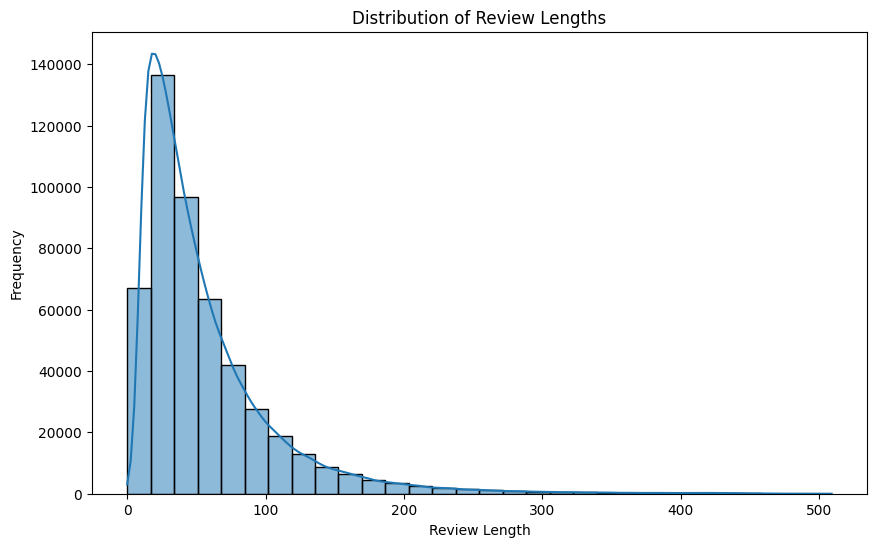

In [30]:
# Plot the distribution of review lengths
# Creating a figure for the plot with a specified size of 10x6 inches
plt.figure(figsize=(10, 6))
# Plotting a histogram of review lengths with 30 bins and a kernel density estimate (KDE) line
sns.histplot(rev_length, bins=30, kde=True)
# Setting the title of the plot
plt.title('Distribution of Review Lengths')
# Setting the x-axis label text
plt.xlabel('Review Length')
# Setting the y-axis label text
plt.ylabel('Frequency')
# Displaying the histogram plot
plt.show()

In [31]:
# Length threshold for reviews
length_threshold = 70

# Filtering the DataFrame to keep only reviews with length <= length_threshold
df_filtered = pand_df[pand_df['review_length'] <= length_threshold]

# Show the filtered DataFrame
print("Filtered DataFrame:")
print(df_filtered)


Filtered DataFrame:
                                                     text  stars  label  \
0       least give restaurant two star due decent food...    2.0      0   
1       never called restaurant nothing restaurant pre...    2.0      0   
2       started artichoke dip big mistake cold chip st...    2.0      0   
5       worst place ive ever visited bouncer rude didn...    1.0      0   
7       called get service information k amg told sinc...    1.0      0   
...                                                   ...    ...    ...   
499346  go benihana probably time year offer dollar co...    3.0      1   
499347  ive multiple time ayce sushi always spoil brim...    5.0      1   
499348  well mooresville steak n shake back finally ti...    5.0      1   
499349  nice place eat packed may want get early going...    4.0      1   
499352  enjoy atmosphere much employee establishment r...    5.0      1   

        review_length  
0                  43  
1                  53  
2      

In [32]:
# Filter the negative reviews
negative_reviews = df_filtered[df_filtered['label'] == 0]['text']

In [33]:
# Join the negative reviews into one big string
negative_reviews_text = " ".join(negative_reviews)

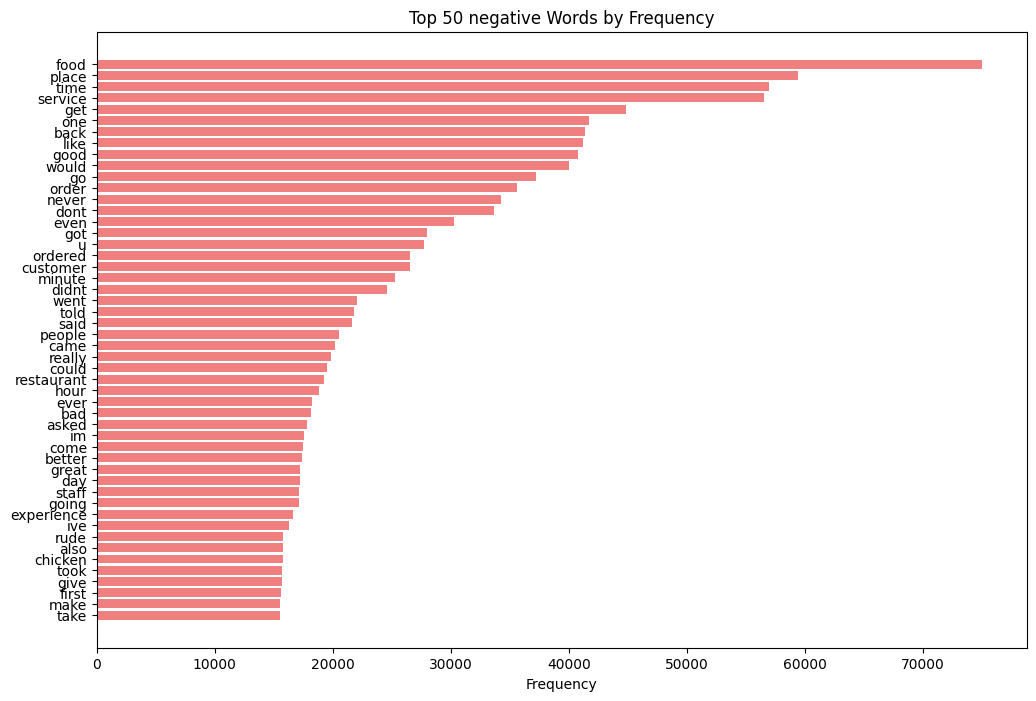

In [115]:
# Importing the Counter class from the collections module to count word frequencies
from collections import Counter

# CountING the frequencies of words in the negative reviews by splitting the text
word_frequencies = Counter(negative_reviews_text.split())

# Filtering to the top 50 word frequencies
top_n = 50

# Getting the top N most common words and their frequencies
most_common_words = word_frequencies.most_common(top_n)

# Unpacking the words and their corresponding frequencies into separate lists
words, frequencies = zip(*most_common_words)


# Normalizing the word frequencies for color mapping in the plot
max_frequency = float(max(frequencies))
colors = plt.cm.viridis([f / max_frequency for f in frequencies])

# Creating a figure for the plot with a specified size of 12x8 inches
plt.figure(figsize=(12, 8))
# Plotting a horizontal bar chart with words on the y-axis and their frequencies on the x-axis
plt.barh(words, frequencies, color='lightcoral')
# Labelling the x-axis as 'Frequency'
plt.xlabel('Frequency')
# Setting the title of the plot
plt.title('Top 50 negative Words by Frequency')
# Inverting the y-axis so the most frequent words appear at the top
plt.gca().invert_yaxis()
# Displaying the plot
plt.show()

In [116]:
# Filter the positive reviews
positive_reviews = df_filtered[df_filtered['label'] == 1]['text']

# Join the negative reviews into one big string
positive_reviews_text = " ".join(positive_reviews)

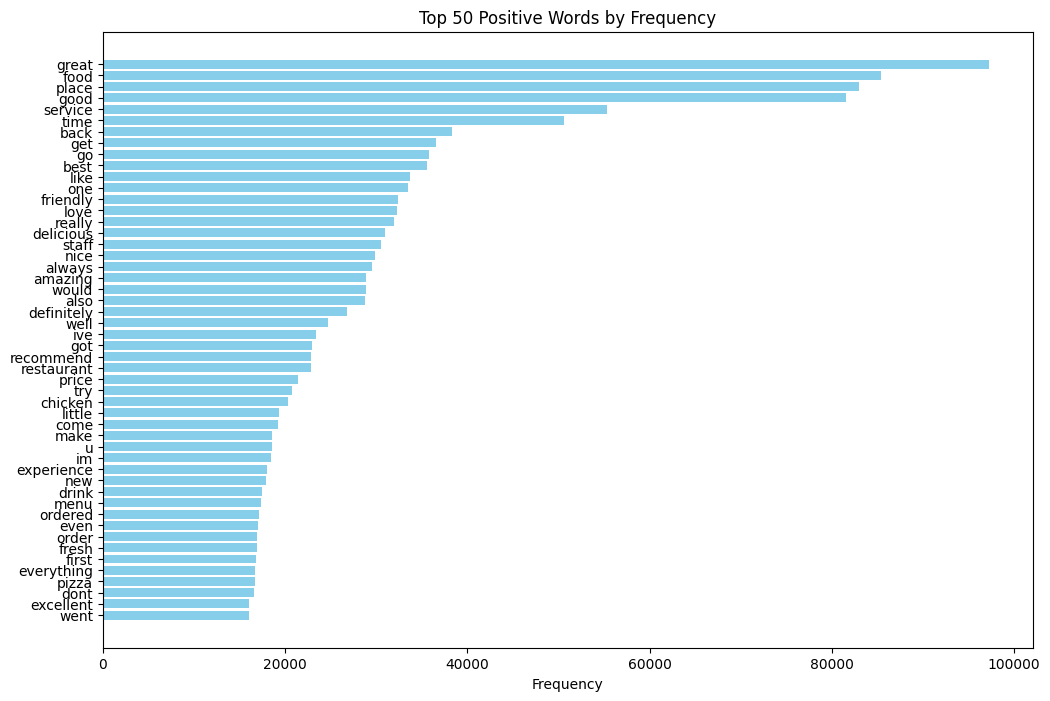

In [117]:
# CountING the frequencies of words in the positive reviews by splitting the text
word_frequencies_positive = Counter(positive_reviews_text.split())

# Filtering to the top 50 word frequencies
top_n = 50
# Getting the top N most common words and their frequencies
most_common_words_positive = word_frequencies_positive.most_common(top_n)

# Unpacking the words and their corresponding frequencies into separate lists
words_positive, frequencies_positive = zip(*most_common_words_positive)

# Normalize frequencies for color mapping
max_frequency_positive = float(max(frequencies_positive))
colors = plt.cm.viridis([f / max_frequency_positive for f in frequencies_positive])

# Creating a figure for the plot with a specified size of 12x8 inches
plt.figure(figsize=(12, 8))
# Plotting a horizontal bar chart with words on the y-axis and their frequencies on the x-axis
plt.barh(words_positive, frequencies_positive, color='skyblue')
# Labelling the x-axis as 'Frequency'
plt.xlabel('Frequency')
# Setting the title of the graph
plt.title('Top 50 Positive Words by Frequency')
# Inverting the y-axis so the most frequent words appear at the top
plt.gca().invert_yaxis()
# Showing the plot
plt.show()

In [37]:
# Converting the filtered text data into sequences of word indices
sequences_filtered = tokenizer.texts_to_sequences(df_filtered['text'])
# Calculating the length of each review sequence
rev_length_filtered = [len(sequence) for sequence in sequences_filtered]
# Adding a new column to the filtered dataframe to store the review lengths
df_filtered['review_length'] = rev_length_filtered

C:\Users\atrav\AppData\Local\Temp\ipykernel_18488\2809772606.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['review_length'] = rev_length_filtered


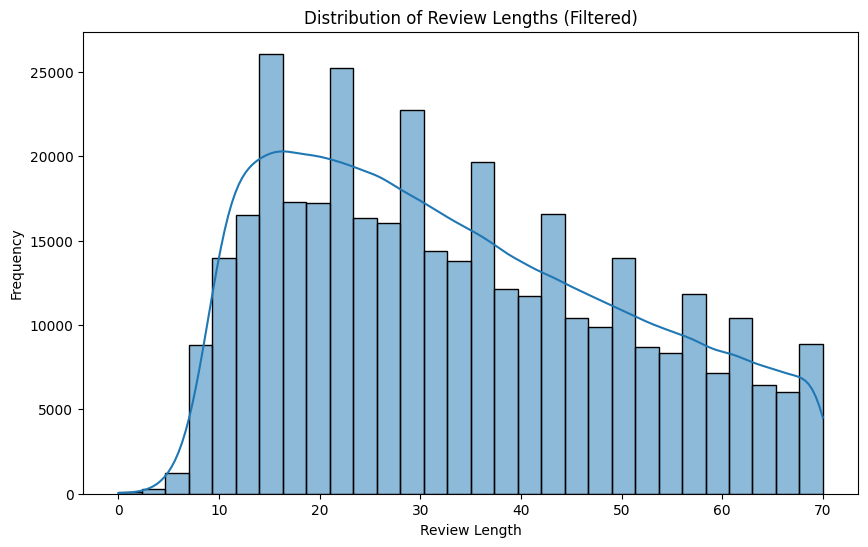

In [38]:
# Creating a figure for the plot with a specified size of 102x6 inches
plt.figure(figsize=(10, 6))
# Plotting a histogram of review lengths with 30 bins and a kernel density estimate (KDE) line
sns.histplot(df_filtered['review_length'], bins=30, kde=True)
# Setting the title text of the plot
plt.title('Distribution of Review Lengths (Filtered)')
# Setting the x-axis label text
plt.xlabel('Review Length')
# Setting the y-axis label text
plt.ylabel('Frequency')
# Showing the plot
plt.show()

In [39]:
# Ensuring that the distribution is still good
# Counting the number of reviews in each category
label_counts = df_filtered['label'].value_counts()
# Mapping each review to a bad or good sentiment
label_mapping = {0: 'bad', 1: 'good'}

# Printing out each 0 and 1 count
print("Number of reviews classified as 'good':", label_counts.get(1, 0))
print("Number of reviews classified as 'bad':", label_counts.get(0, 0))

Number of reviews classified as 'good': 200860
Number of reviews classified as 'bad': 171413


In [40]:
# Initializing the LabelEncoder()
label_encoder = LabelEncoder()
# Applying label_encoder to each entry in the 'label column'
df_filtered['label'] = label_encoder.fit_transform(df_filtered['label'])

C:\Users\atrav\AppData\Local\Temp\ipykernel_18488\1935292074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = label_encoder.fit_transform(df_filtered['label'])


In [41]:
# Padding the sequences to ensure all reviews have the same length (70 in this case)
X = pad_sequences(sequences_filtered, maxlen=70)
# Extracting the labels from the filtered dataframe
y = df_filtered['label'].values

# Printing the padded sequences (X)
print(X)
# Printing the corresponding labels (y)
print(y)

[[    0     0     0 ...   548   503  1102]
 [    0     0     0 ...     7  4054    41]
 [    0     0     0 ...  1318   105     3]
 ...
 [    0     0     0 ...     3   587  2497]
 [    0     0     0 ...   501    53   492]
 [    0     0     0 ... 12799 17860  3174]]
[0 0 0 ... 1 1 1]


In [42]:
# Importing pickle to save and load data
import pickle
# Importing train_test_split to split the data into X and y training and testing sets
from sklearn.model_selection import train_test_split

# Splitting the data into X and y test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Saving the split data using pickles
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# **Simple RNN Model**
---

In [43]:
# Using pickles to load the data, saved earlier. Each load is saved into a new variable
with open('X_train.pkl', 'rb') as f:
    X_train_simple = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test_simple = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train_simple = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test_simple = pickle.load(f)

In [44]:
# Finding the shape of the X_train data
X_train.shape

(297818, 70)

In [45]:
# Finding the shape of the y_train data
y_train.shape

(297818,)

In [119]:
# Initializing a sequential model for the Simple RNN
simple_rnn_model = Sequential()
# Adding an embedding layer with input dimension of 25,000 (vocabulary size), output dimension of 128 (embedding size), and input length of 70 (maximum sequence length)
simple_rnn_model.add(Embedding(input_dim=25000, output_dim=128, input_length=70))
# Adding a SimpleRNN layer with 128 units and ReLU activation function
simple_rnn_model.add(SimpleRNN(128, activation='relu')) 
# Adding a dense output layer with 1 unit and a sigmoid activation for binary classification
simple_rnn_model.add(Dense(1, activation='sigmoid')) 

# Printing the model summary
simple_rnn_model.summary()

# Compiling the model with binary cross-entropy loss, adam optimizer, and accuracy as the evaluation metric
simple_rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model on the training data, using 20% of the data for validation, over 3 epochs, with a batch size of 64
simple_rnn_history = simple_rnn_model.fit(X_train_simple, 
                                          y_train_simple, 
                                          epochs=3, 
                                          batch_size=64, 
                                          validation_split=0.2, 
                                          validation_data=(X_test_simple, y_test_simple)) 

# Saving the trained model to a file named 'simpleRNN_model.h5'
simple_rnn_model.save('simpleRNN_model.h5')


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 143s 30ms/step - accuracy: 0.8805 - loss: 0.2774 - val_accuracy: 0.9213 - val_loss: 0.2015
Epoch 2/3
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 137s 29ms/step - accuracy: 0.9327 - loss: 0.1760 - val_accuracy: 0.9202 - val_loss: 0.2011
Epoch 3/3
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 132s 28ms/step - accuracy: 0.9432 - loss: 0.1501 - val_accuracy: 0.9218 - val_loss: 0.2087


In [47]:
# Evaluating the Simple RNN model on the test set (X_test_simple and y_test_simple) and returning the loss and accuracy
simple_score = simple_rnn_model.evaluate(X_test_simple, y_test_simple)
# Printing the accuracy of the Simple RNN model, multiplying the accuracy score by 100 to display it as a percentage
print(f"Simple RNN Model Accuracy: {simple_score[1]*100:.2f}%")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9208 - loss: 0.2110
Simple RNN Model Accuracy: 92.05%


In [48]:
# Evaluating the Simple RNN model on the test set (X_test_simple and y_test_simple)
# 'loss' stores the binary cross-entropy loss, and 'accuracy' stores the model's accuracy
loss, accuracy = simple_rnn_model.evaluate(X_test_simple, y_test_simple, verbose=1)
# Printing the validation loss value
print(f"Validation Loss: {loss}")
# Printing the validation accuracy value
print(f"Validation Accuracy: {accuracy}")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9208 - loss: 0.2110
Validation Loss: 0.21143335103988647
Validation Accuracy: 0.9204888939857483


In [49]:
# Making predictions on new data, only 5
predictions = simple_rnn_model.predict(X_test_simple[:5])
# Printing the predictions made
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
[[0.99077606]
 [0.9980397 ]
 [0.09168285]
 [0.02439966]
 [0.18219382]]


In [50]:
# Getting the predicted class labels from the model's predictions
# Using np.argmax to return the index of the highest probability class (for multi-class classification)
predicted_classes = np.argmax(predictions, axis=1)
# Printing the class predictions
print("Predicted classes:", predicted_classes)

Predicted classes: [0 0 0 0 0]


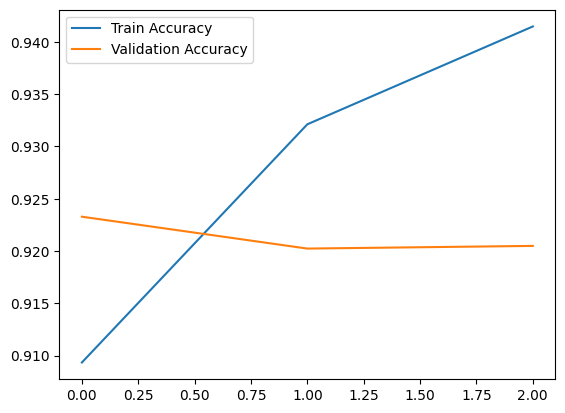

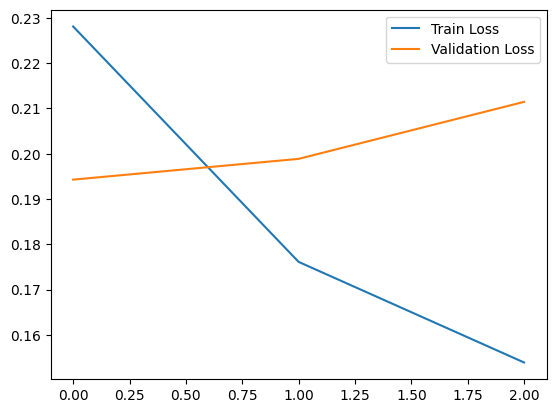

In [51]:
# Plotting training and validation accuracy over epochs
plt.plot(simple_rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(simple_rnn_history.history['val_accuracy'], label='Validation Accuracy')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

# Plotting training and validation loss over epochs
plt.plot(simple_rnn_history.history['loss'], label='Train Loss')
plt.plot(simple_rnn_history.history['val_loss'], label='Validation Loss')
# Showning the legend on the graph
plt.legend()
# Showing the plot
plt.show()

In [52]:
# Predicting the probabilities for the test set
y_pred_simple_prob = simple_rnn_model.predict(X_test_simple)

# Converting probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_simple = (y_pred_simple_prob > 0.5).astype(int)

# Generating the confusion matrix of y_test_simple and y_pred_simple
conf_matrix_simple = confusion_matrix(y_test_simple, y_pred_simple)
# Printing the confusion matrix
print(conf_matrix_simple)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
[[31382  2942]
 [ 2978 37153]]


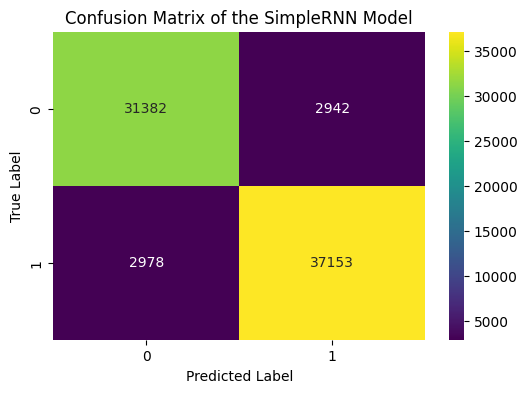

In [120]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
# Generating a heatmap fo rthe confusion matrix
sns.heatmap(conf_matrix_simple, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the SimpleRNN Model')
# Setting the y label text
plt.ylabel('True Label')
# Setting the x label text
plt.xlabel('Predicted Label')

# Showing the plot
plt.show()

# **LSTM Model 1**
---

In [54]:
# Loading the saved data from earlier into new variables used for this first LSTM model
with open('X_train.pkl', 'rb') as f:
    X_train_LSTM1 = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test_LSTM1 = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train_LSTM1 = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test_LSTM1 = pickle.load(f)

In [55]:
# Initializing a sequential model
LSTM_model_1 = Sequential()

# Adding an embedding layer as it converts integer-encoded vocabulary into dense vectors of fixed sizes
LSTM_model_1.add(Embedding(input_dim=25000, output_dim=128, input_length=70))

# Adding lstm layer with 64 units.
# Retun sequences is set to false as only the output of the last timestep is returned. This is suitable for classification tasks
LSTM_model_1.add(LSTM(64, return_sequences=False, dropout=0.3))

# Adding a dense layer for the output layer with 1 unit and sigmoid activation for binary classification
LSTM_model_1.add(Dense(1, activation='sigmoid'))

# Printing the summary of all the details about the model's layers, number of parameters, etc.
LSTM_model_1.summary()

# Compiling the model using binary_crossentropy as a loss function as it is suitable for binary classification tasks.
LSTM_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting, waiting 3 epochs before stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

# Training the model with 20 epochs and 64 bacth sizing
LSTM_model_1_history = LSTM_model_1.fit(X_train_LSTM1, 
                                          y_train_LSTM1, 
                                          epochs=20, 
                                          batch_size=64, 
                                          validation_split=0.2, 
                                          validation_data=(X_test_LSTM1, y_test_LSTM1),
                                          callbacks=[early_stopping]) 

# Saving the model so that it can be loaded later on without running again
LSTM_model_1.save('LSTM_model_1_model.h5')

c:\Users\atrav\anaconda3\envs\pdan_part1\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 184s 39ms/step - accuracy: 0.8943 - loss: 0.2516 - val_accuracy: 0.9266 - val_loss: 0.1851
Epoch 2/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 183s 39ms/step - accuracy: 0.9359 - loss: 0.1613 - val_accuracy: 0.9295 - val_loss: 0.1803
Epoch 3/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 181s 39ms/step - accuracy: 0.9456 - loss: 0.1370 - val_accuracy: 0.9271 - val_loss: 0.1895
Epoch 4/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 180s 39ms/step - accuracy: 0.9541 - loss: 0.1168 - val_accuracy: 0.9264 - val_loss: 0.2013
Epoch 5/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 181s 39ms/step - accuracy: 0.9615 - loss: 0.0976 - val_accuracy: 0.9244 - val_loss: 0.2209


In [56]:
# Evaluating the first lstm model on the test set (X_test_LSTM1 and y_test_LSTM1) and returning the loss and accuracy
simple_score_lstm1 = LSTM_model_1.evaluate(X_test_LSTM1, )
# Printing the loss and accuracy
print(f"Simple RNN Model Accuracy: {simple_score_lstm1[1]*100:.2f}%")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9309 - loss: 0.1778
Simple RNN Model Accuracy: 92.95%


In [57]:
# Evaluating the first lstm model on the test set (X_test_LSTM1 and y_test_LSTM1)
# 'loss' stores the binary cross-entropy loss, and 'accuracy' stores the model's accuracy
loss, accuracy = LSTM_model_1.evaluate(X_test_LSTM1, y_test_LSTM1, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9309 - loss: 0.1778
Validation Loss: 0.1802695393562317
Validation Accuracy: 0.9294875860214233


In [58]:
# Making predictions on new data
predictions = LSTM_model_1.predict(X_test_LSTM1[:5])
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
[[0.934727  ]
 [0.978955  ]
 [0.13591804]
 [0.00267435]
 [0.24596089]]


In [59]:
# Getting the predicted class labels from the model's predictions
# Using np.argmax to return the index of the highest probability class (for multi-class classification)
predicted_classes = np.argmax(predictions, axis=1)
# Printing the class predictions
print("Predicted classes:", predicted_classes)

Predicted classes: [0 0 0 0 0]


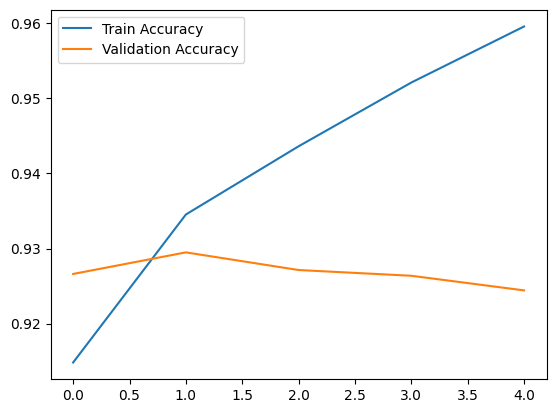

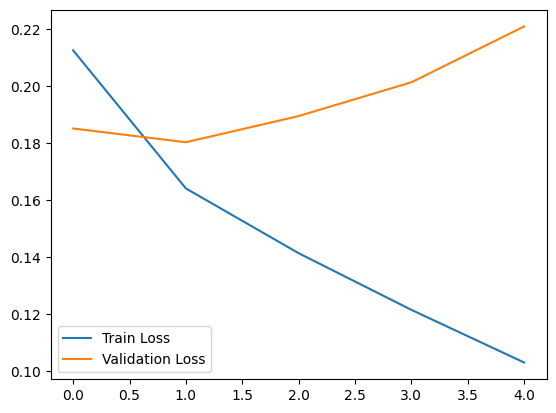

In [60]:
# Plotting training and validation accuracy over epochs
plt.plot(LSTM_model_1_history.history['accuracy'], label='Train Accuracy')
plt.plot(LSTM_model_1_history.history['val_accuracy'], label='Validation Accuracy')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

# Plotting training and validation loss over epochs
plt.plot(LSTM_model_1_history.history['loss'], label='Train Loss')
plt.plot(LSTM_model_1_history.history['val_loss'], label='Validation Loss')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

In [61]:
# Predicting the probabilities for the test set
y_pred_lstm = LSTM_model_1.predict(X_test_LSTM1)

# Converting probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_lstm1 = (y_pred_lstm > 0.5).astype(int)

# Generating the confusion matrix for the first LSTM model
conf_matrix_lstm1 = confusion_matrix(y_test_LSTM1, y_pred_lstm1)
# Printing the confusion matrix values
print(conf_matrix_lstm1)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step
[[31973  2351]
 [ 2899 37232]]


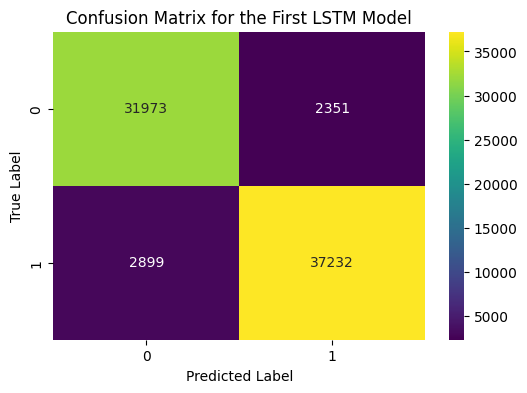

In [121]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_lstm1, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix for the First LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

# **Sauced-Up *LSTM* Model**
---

In [63]:
# Loading the X_train ('x' training) data for the 'auced_lstm' model
with open('X_train.pkl', 'rb') as f:
    X_train_sauced_lstm = pickle.load(f)

    # Loading the X_test ('x' testing) data for the 'sauced_lstm' model
with open('X_test.pkl', 'rb') as f:
    X_test_sauced_lstm = pickle.load(f)

    # Loading the y_train ('y' training) data for the 'sauced_lstm' model
with open('y_train.pkl', 'rb') as f:
    y_train_sauced_lstm = pickle.load(f)

    # Loading the y_train ('y' testing) data for the 'sauced_lstm' model
with open('y_test.pkl', 'rb') as f:
    y_test_sauced_lstm = pickle.load(f)

In [64]:
# Initializing a sequential model
sauced_lstm = Sequential()

# Adding an Embedding layer
# This layer converts integer-encoded vocabulary into dense vectors of fixed size, in my case, 128
sauced_lstm.add(Embedding(input_dim=25000, output_dim=128, input_length=70))

# Adding the first LSTM layer
sauced_lstm.add(LSTM(128, return_sequences=True, recurrent_dropout=0.3))
# Added an additional dropout layer for ensuring regularization
sauced_lstm.add(Dropout(0.3))  

# Added a second LSTM Layer
# This layer has return_sequences=False, the output will be fed into a dense layer
sauced_lstm.add(LSTM(128, return_sequences=False, recurrent_dropout=0.3))
# Added an additional dropout layer for ensuring regularization
sauced_lstm.add(Dropout(0.3))

# Added a Batch Normalization layer
# This helps to stabilize and speed up training
sauced_lstm.add(BatchNormalization())

# Added first Dense layer
# This is a hidden dense layer with 64 units and ReLU activation
sauced_lstm.add(Dense(64, activation='relu'))

# I added an additional dropout layer for regularization
sauced_lstm.add(Dropout(0.3))  

# Added the last layer as a dense output layer with 1 unit and sigmoid activation for binary classification
sauced_lstm.add(Dense(1, activation='sigmoid'))

# Printing the summary of the model architecture
sauced_lstm.summary()

# Compiling the LSTM model, using binary cross-entropy loss as this is binary classification
# Adam  optimizer is used at a learning rate of 0.001 for effective gradient updates
sauced_lstm.compile(
    loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']
)

# Making use of the earlystopping callback so that it can monitor the 'val_loss' during validation
# I have also set the patience of the earlytopping to to 3, so that the training stops if there is no improvements found within 3 epochs
# And ofcourse, I restore best weights to ensure I am left with the best weights found during training.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

# Reducing learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor; the learning rate will be reduced based on the validation loss
    factor=0.2, 
    patience=3,             # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00005, 
    verbose=1
)

# Fitting the sauced_lstm model using the X_train_sauced_lstm and y_train_sauced_lstm retrieved using pickles earlier.
# I set epochs = 20 just so that the model has enough epochs to itterate through, to ensure as best of fit as possible.
sauced_lstm_history = sauced_lstm.fit(
    X_train_sauced_lstm, 
    y_train_sauced_lstm, 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2, 
    validation_data=(X_test_sauced_lstm, y_test_sauced_lstm),
    callbacks=[early_stopping, reduce_lr]
)

c:\Users\atrav\anaconda3\envs\pdan_part1\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 482s 103ms/step - accuracy: 0.8883 - loss: 0.2713 - val_accuracy: 0.9256 - val_loss: 0.1996 - learning_rate: 0.0010
Epoch 2/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 484s 104ms/step - accuracy: 0.9326 - loss: 0.1741 - val_accuracy: 0.9281 - val_loss: 0.1811 - learning_rate: 0.0010
Epoch 3/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 495s 106ms/step - accuracy: 0.9428 - loss: 0.1482 - val_accuracy: 0.9277 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 4/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 498s 107ms/step - accuracy: 0.9514 - loss: 0.1266 - val_accuracy: 0.9245 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 5/20
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9594 - loss: 0.1047
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 491s 106ms/step - accuracy: 0.9594 - loss: 0.1047 - val_accuracy: 0.9232 - val_loss: 0.2119 - learning_rate: 0.0010


In [65]:
# Saving the Sauced up lstm model
sauced_lstm.save('sauced_lstm_model.h5')

In [66]:
# Evaluating the sauced_lstm model on the test set (X_test_sauced_lstm and y_test_sauced_lstm) and returning the loss and accuracy
sauced_lstm_score = sauced_lstm.evaluate(X_test_sauced_lstm, y_test_sauced_lstm)
# Printing the accuracy
print(f"Sauced LSTM Model Accuracy: {sauced_lstm_score[1]*100:.2f}%")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.9281 - loss: 0.1812
Sauced LSTM Model Accuracy: 92.81%


In [67]:
# Evaluating the sauced_lstm model on the test set (X_test_sauced_lstm and y_test_sauced_lstm)
# 'loss' stores the binary cross-entropy loss, and 'accuracy' stores the model's accuracy
loss, accuracy = sauced_lstm.evaluate(X_test_sauced_lstm, y_test_sauced_lstm, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.9281 - loss: 0.1812
Validation Loss: 0.1811254769563675
Validation Accuracy: 0.9280773401260376


In [68]:
# Making predictions on new data
sauced_predictions = sauced_lstm.predict(X_test_sauced_lstm[:5])
print(sauced_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
[[0.9794623 ]
 [0.97347605]
 [0.09778053]
 [0.01085423]
 [0.17908157]]


In [69]:
# Getting the predicted class labels from the model's predictions
# Using np.argmax to return the index of the highest probability class (for multi-class classification)
sauced_predicted_classes = np.argmax(predictions, axis=1)
# Printing the class prediciton
print("Predicted classes:", sauced_predicted_classes)

Predicted classes: [0 0 0 0 0]


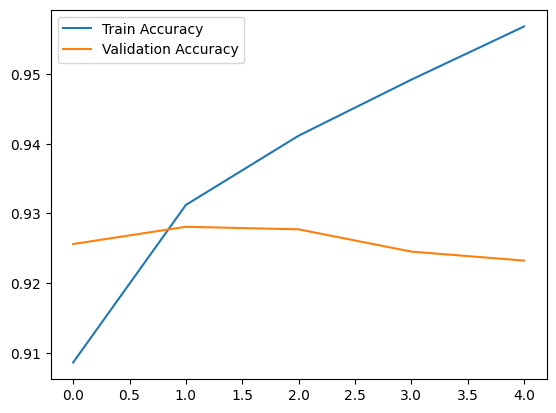

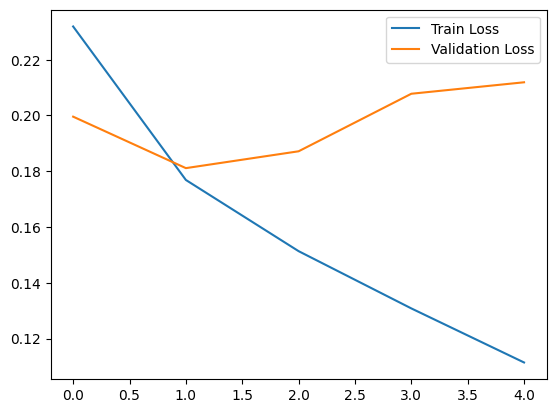

In [70]:
# Plotting training and validation accuracy over epochs
plt.plot(sauced_lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(sauced_lstm_history.history['val_accuracy'], label='Validation Accuracy')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

# Plotting training and validation loss over epochs
plt.plot(sauced_lstm_history.history['loss'], label='Train Loss')
plt.plot(sauced_lstm_history.history['val_loss'], label='Validation Loss')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

In [71]:
# Predicting the probabilities for the test set
y_pred_prob_sauced = sauced_lstm.predict(X_test_sauced_lstm)

# Converting probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_sauced = (y_pred_prob_sauced > 0.5).astype(int)

# Generating a confusion matrix for the sauced_lstm models predictions
conf_matrix_sauced = confusion_matrix(y_test_sauced_lstm, y_pred_sauced)
print(conf_matrix_sauced)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step
[[32427  1897]
 [ 3458 36673]]


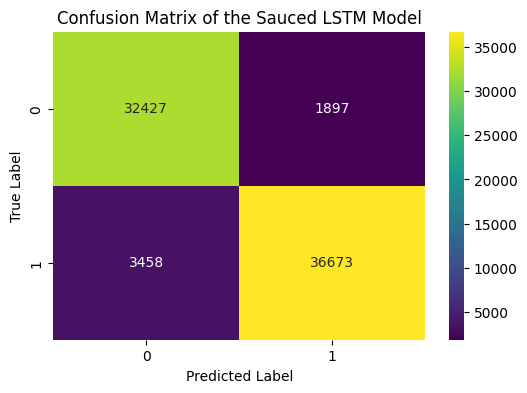

In [72]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_sauced, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the Sauced LSTM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Showing the plot
plt.show()

**Overfit-Resistant LSTM Model**
---

In [73]:
# Loading the X_train ('x' training) data for the 'overfit_resistant' model
with open('X_train.pkl', 'rb') as f:
    X_train_lstm_resistant = pickle.load(f)
# Loading the X_test ('x' test) data for the 'overfit_resistant' model
with open('X_test.pkl', 'rb') as f:
    X_test_lstm_resistant = pickle.load(f)
# Loading the y_training ('y' training) data for the 'overfit_resistant' model
with open('y_train.pkl', 'rb') as f:
    y_train_lstm_resistant = pickle.load(f)
# Loading the y_test ('y' test) data for the 'overfit_resistant' model
with open('y_test.pkl', 'rb') as f:
    y_test_lstm_resistant = pickle.load(f)

In [76]:
from tensorflow.keras.regularizers import l2
# Initializing a sequential model
overfit_resistant_lstm = Sequential()

# Adding an Embedding layer
# This layer converts integer-encoded vocabulary into dense vectors of fixed size, in this case, 128
overfit_resistant_lstm.add(Embedding(input_dim=25000, output_dim=128, input_length=70))

# Adding the first LSTM layer
# Reduced the number of units to 64 to avoid over-complexity and overfitting
overfit_resistant_lstm.add(LSTM(64, return_sequences=True, recurrent_dropout=0.4, kernel_regularizer=l2(0.001)))
# Added a higher dropout rate of 0.4 to regularize more aggressively
overfit_resistant_lstm.add(Dropout(0.4))
# Added a Batch Normalization layer to stabilize and improve convergence
overfit_resistant_lstm.add(BatchNormalization())  

# Added a second LSTM Layer
# Reduced the number of units again and no return_sequences (output will be fed into a dense layer)
overfit_resistant_lstm.add(LSTM(32, return_sequences=False, recurrent_dropout=0.4))
# Dropout layer with a rate of 0.4 for additional regularization
overfit_resistant_lstm.add(Dropout(0.4))
# Added a Batch Normalization layer to stabilize and improve convergence
overfit_resistant_lstm.add(BatchNormalization())

# Added the first Dense layer
# Using fewer units (32) in the hidden dense layer to reduce the model capacity, also ReLU activation
overfit_resistant_lstm.add(Dense(32, activation='relu'))

# Another dropout layer with a rate of 0.4 to further regularize the dense layer
overfit_resistant_lstm.add(Dropout(0.4))  

# Added the output layer with 1 unit and sigmoid activation for binary classification
overfit_resistant_lstm.add(Dense(1, activation='sigmoid'))

# Printing the summary of the new model architecture
overfit_resistant_lstm.summary()

# Compiling the LSTM model with binary cross-entropy loss and Adam optimizer
# Lowering the learning rate to 0.0005 for smaller steps during optimization to prevent overfitting
overfit_resistant_lstm.compile(
    loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy']
)

# Defining early stopping with a shorter patience and restoring the best weights
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=2,
    restore_best_weights=True
)

# Reducing the learning rate when validation loss plateaus with stricter conditions
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2,  # Quicker reduction of learning rate to adapt training
    min_lr=0.00001,  # A lower minimum learning rate to explore smaller steps
    verbose=1
)

# Fitting the model with additional validation and reduced epochs to prevent overfitting
overfit_resistant_lstm_history = overfit_resistant_lstm.fit(
    X_train_lstm_resistant, 
    y_train_lstm_resistant, 
    epochs=15,  # Reducing the total epochs to limit overfitting
    batch_size=64, 
    validation_split=0.2, 
    validation_data=(X_test_lstm_resistant, y_test_lstm_resistant),
    callbacks=[early_stopping, reduce_lr]
)


c:\Users\atrav\anaconda3\envs\pdan_part1\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 285s 60ms/step - accuracy: 0.8639 - loss: 0.3602 - val_accuracy: 0.9175 - val_loss: 0.2139 - learning_rate: 5.0000e-04
Epoch 2/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 278s 60ms/step - accuracy: 0.9201 - loss: 0.2180 - val_accuracy: 0.9192 - val_loss: 0.2056 - learning_rate: 5.0000e-04
Epoch 3/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 279s 60ms/step - accuracy: 0.9273 - loss: 0.1946 - val_accuracy: 0.9218 - val_loss: 0.2025 - learning_rate: 5.0000e-04
Epoch 4/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 274s 59ms/step - accuracy: 0.9325 - loss: 0.1790 - val_accuracy: 0.9223 - val_loss: 0.2054 - learning_rate: 5.0000e-04
Epoch 5/15
4653/4654 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9374 - loss: 0.1675
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 277s 59ms/step - accuracy: 0.9374 - loss: 0.1675 - val_accuracy: 0.9221 - val_loss: 0.2050 - learning_rate: 5.0000e-04


In [77]:
# Saving the overfit_resistant model
overfit_resistant_lstm.save('overfit_resistant)lstm_model.h5')

In [78]:
# Evaluating the overfit_resistant model on the test set (X_test_lstm_resistant and y_test_lstm_resistant) and returning the loss and accuracy
resistant_lstm_score = overfit_resistant_lstm.evaluate(X_test_lstm_resistant, y_test_lstm_resistant)
# Printing the model accuracy.
print(f"Sauced LSTM Model Accuracy: {resistant_lstm_score[1]*100:.2f}%")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9224 - loss: 0.2021
Sauced LSTM Model Accuracy: 92.18%


In [79]:
# Evaluating the overfit_resistant model on the test set (X_test_lstm_resistant and y_test_lstm_resistant)
# 'loss' stores the binary cross-entropy loss, and 'accuracy' stores the model's accuracy
loss, accuracy = overfit_resistant_lstm.evaluate(X_test_lstm_resistant, y_test_lstm_resistant, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9224 - loss: 0.2021
Validation Loss: 0.20251506567001343
Validation Accuracy: 0.9218185544013977


In [80]:
# Making predictions on new data
resistant_lstm_prediction = overfit_resistant_lstm.predict(X_test_lstm_resistant[:5])
print(resistant_lstm_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
[[0.9894845 ]
 [0.9932356 ]
 [0.11287796]
 [0.02773241]
 [0.35063964]]


In [81]:
# Printing the classes each prediciton belongs to
overfit_lst_classes = np.argmax(resistant_lstm_prediction, axis=1)
print("Predicted classes:", overfit_lst_classes)

Predicted classes: [0 0 0 0 0]


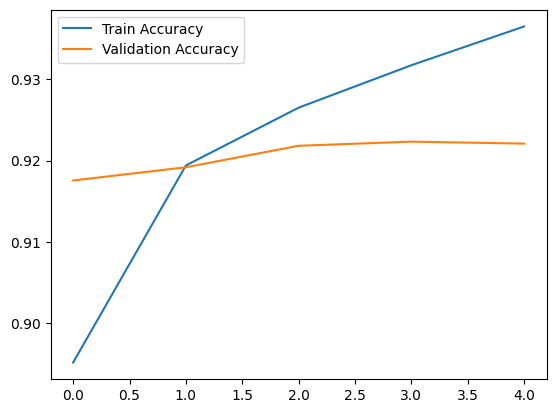

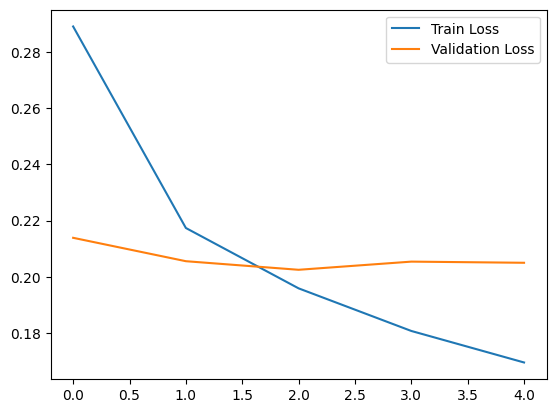

In [82]:
# Plotting training and validation accuracy over epochs
plt.plot(overfit_resistant_lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(overfit_resistant_lstm_history.history['val_accuracy'], label='Validation Accuracy')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

# Plotting training and validation loss over epochs
plt.plot(overfit_resistant_lstm_history.history['loss'], label='Train Loss')
plt.plot(overfit_resistant_lstm_history.history['val_loss'], label='Validation Loss')
# Adding a legend to the plot
plt.legend()
# Shwoing the plot
plt.show()

In [83]:
# Predicting the probabilities for the test set
y_pred_prob_resistant = overfit_resistant_lstm.predict(X_test_lstm_resistant)

# Converting probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred_overfit_resistant = (y_pred_prob_resistant > 0.5).astype(int)

conf_matrix_overfit_resistant = confusion_matrix(y_test_lstm_resistant, y_pred_overfit_resistant)
print(conf_matrix_overfit_resistant)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step
[[31856  2468]
 [ 3353 36778]]


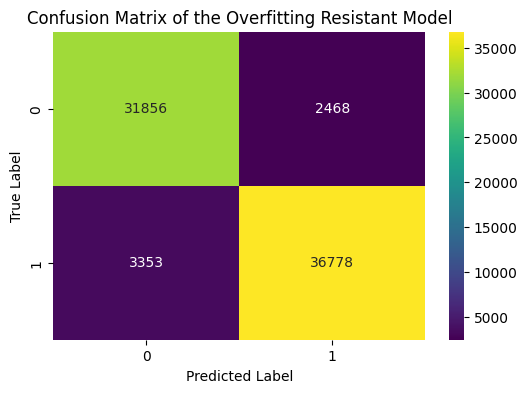

In [84]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_overfit_resistant, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the Overfitting Resistant Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

**Overfitting Improved Model**
---

In [104]:
# Opening and retrieving the X_train (train) data for the improved model
with open('X_train.pkl', 'rb') as f:
    X_train_improved = pickle.load(f)

# Opening and retrieving the X_test (test) data for the improved model
with open('X_test.pkl', 'rb') as f:
    X_test_improved = pickle.load(f)

# Opening and retrieving the y_train (training) data for the improved model
with open('y_train.pkl', 'rb') as f:
    y_train_improved = pickle.load(f)

# Opening and retrieving the y_test (test) data for the improved model
with open('y_test.pkl', 'rb') as f:
    y_test_improved = pickle.load(f)

In [105]:
from tensorflow.keras.regularizers import l1_l2

# Initializing a sequential model
overfit_improved_model = Sequential()

# Adding an Embedding layer
# This layer converts integer-encoded vocabulary into dense vectors of fixed size, in this case, 128
overfit_improved_model.add(Embedding(input_dim=25000, output_dim=128, input_length=70))

# Adding the first LSTM layer
# Reduced the number of units to 32 to avoid over-complexity and overfitting
overfit_improved_model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.4, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
# Added a higher dropout rate of 0.5 to regularize more aggressively
overfit_improved_model.add(Dropout(0.5))
# Added a Batch Normalization layer to stabilize and improve convergence
overfit_improved_model.add(BatchNormalization())  

# Added a second LSTM Layer
# Reduced the number of units again and no return_sequences (output will be fed into a dense layer)
overfit_improved_model.add(LSTM(16, return_sequences=False, recurrent_dropout=0.4, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
# Dropout layer with a rate of 0.5 for additional regularization
overfit_improved_model.add(Dropout(0.5))
# Added a Batch Normalization layer to stabilize and improve convergence
overfit_improved_model.add(BatchNormalization())

# Added the first Dense layer
# Using fewer units (32) in the hidden dense layer to reduce the model capacity, also ReLU activation
overfit_improved_model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001)))
# Another dropout layer with a rate of 0.5 to further regularize the dense layer
overfit_improved_model.add(Dropout(0.5))  
overfit_improved_model.add(BatchNormalization())


# Added the output layer with 1 unit and sigmoid activation for binary classification
overfit_improved_model.add(Dense(1, activation='sigmoid'))

# Printing the summary of the new model architecture
overfit_improved_model.summary()

# Compiling the LSTM model with binary cross-entropy loss and Adam optimizer
# Lowering the learning rate to 0.0005 for smaller steps during optimization to prevent overfitting
overfit_improved_model.compile(
    loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005, beta_1=0.85, beta_2=0.995), metrics=['accuracy']
)

# Defining early stopping with a shorter patience and restoring the best weights
early_stopping_improved = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True
)

# Reducing the learning rate when validation loss plateaus with stricter conditions
reduce_lr__improved = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2,  # Quicker reduction of learning rate to adapt training
    min_lr=0.00001,  # A lower minimum learning rate to explore smaller steps
    verbose=1
)

# Fitting the model with additional validation and reduced epochs to prevent overfitting
overfit_improved_history = overfit_improved_model.fit(
    X_train_improved, 
    y_train_improved, 
    epochs=15,  # Reducing the total epochs to limit overfitting
    batch_size=64, 
    validation_split=0.2, 
    validation_data=(X_test_improved, y_test_improved),
    callbacks=[early_stopping_improved, reduce_lr__improved]
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 229s 48ms/step - accuracy: 0.8362 - loss: 0.8234 - val_accuracy: 0.9086 - val_loss: 0.2679 - learning_rate: 5.0000e-04
Epoch 2/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 218s 47ms/step - accuracy: 0.9077 - loss: 0.2826 - val_accuracy: 0.9096 - val_loss: 0.2461 - learning_rate: 5.0000e-04
Epoch 3/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 217s 47ms/step - accuracy: 0.9139 - loss: 0.2564 - val_accuracy: 0.9173 - val_loss: 0.2297 - learning_rate: 5.0000e-04
Epoch 4/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 215s 46ms/step - accuracy: 0.9175 - loss: 0.2440 - val_accuracy: 0.9152 - val_loss: 0.2239 - learning_rate: 5.0000e-04
Epoch 5/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 223s 48ms/step - accuracy: 0.9195 - loss: 0.2364 - val_accuracy: 0.9205 - val_loss: 0.2220 - learning_rate: 5.0000e-04
Epoch 6/15
4654/4654 ━━━━━━━━━━━━━━━━━━━━ 213s 46ms/step - accuracy: 0.9215 - loss: 0.2292 - val_accuracy: 0.8943 - val_loss: 0.2845 - learning_rate: 5.0000e-04
Epoch 7/15
4654/4654 ━━━━━━━━━━━━━

In [106]:
# Saving the overfit_improved model
overfit_improved_model.save('overfit_improved_model.h5')

In [107]:
improved_model_score = overfit_improved_model.evaluate(X_test_improved, y_test_improved)
print(f"Sauced LSTM Model Accuracy: {improved_model_score[1]*100:.2f}%")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9256 - loss: 0.2091
Sauced LSTM Model Accuracy: 92.46%


In [108]:
# Evaluating the model; printing the model validation loss and accuracy.
loss_imroved, accuracy_improved = overfit_improved_model.evaluate(X_test_improved, y_test_improved, verbose=1)
print(f"Validation Loss: {loss_imroved}")
print(f"Validation Accuracy: {accuracy_improved}")

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9256 - loss: 0.2091
Validation Loss: 0.20975035429000854
Validation Accuracy: 0.924598753452301


In [109]:
# Making predictions on new data
improved_predictions = overfit_improved_model.predict(X_test_improved[:5])  # Predicting on the first 5 samples
print(improved_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
[[0.9851887 ]
 [0.979545  ]
 [0.21156552]
 [0.00633351]
 [0.13565035]]


In [110]:
# Printing the classes each prediciton belongs to
improved_classes = np.argmax(improved_predictions, axis=1)
print("Predicted classes:", improved_classes)

Predicted classes: [0 0 0 0 0]


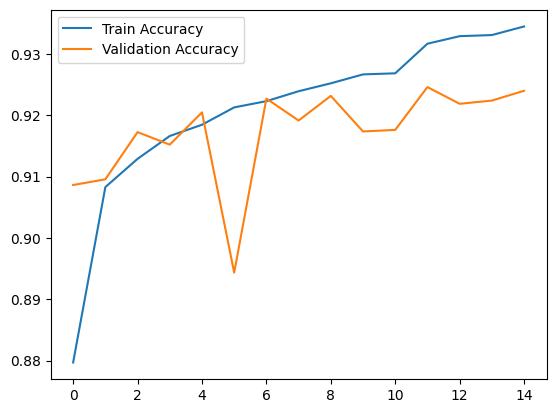

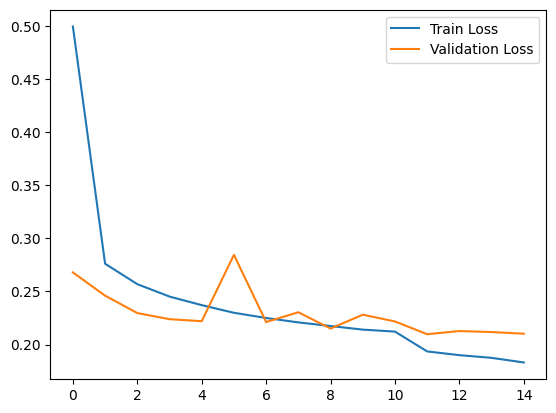

In [111]:
# Plotting training and validation accuracy over epochs
plt.plot(overfit_improved_history.history['accuracy'], label='Train Accuracy')
plt.plot(overfit_improved_history.history['val_accuracy'], label='Validation Accuracy')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

# Plotting training and validation loss over epochs
plt.plot(overfit_improved_history.history['loss'], label='Train Loss')
plt.plot(overfit_improved_history.history['val_loss'], label='Validation Loss')
# Adding a legend to the plot
plt.legend()
# Showing the plot
plt.show()

In [125]:
# Predicting the probabilities for the test set
y_pred_prob_improved = overfit_improved_model.predict(X_test_improved)

# Converting probabilities to binary predictions (0 or 1) using a threshold of 0.5z
y_pred_overfit_improved = (y_pred_prob_improved > 0.5).astype(int)

conf_matrix_overfit_improved = confusion_matrix(y_test_improved, y_pred_overfit_improved)
print(conf_matrix_overfit_improved)

2327/2327 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step
[[31801  2523]
 [ 3091 37040]]


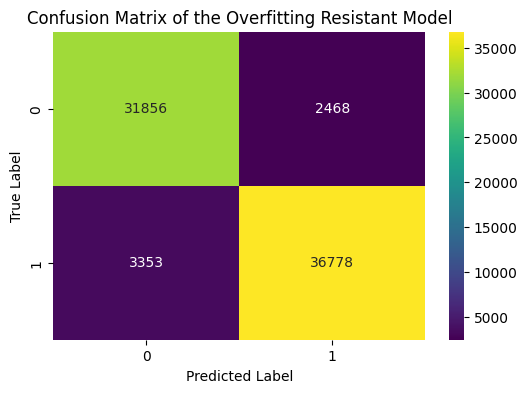

In [126]:
# Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_overfit_resistant, annot=True, fmt='d', cmap='viridis')

# Adding labels and title for the confusion matrix plot
plt.title('Confusion Matrix of the Overfitting Resistant Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()

# **Model Testing**
---

In [86]:
from tensorflow.keras.models import load_model
# Loading the previously saved LSTM model from the specified file
loaded_sauced_lstm = load_model('overfit_improved_model.h5')

In [127]:
# Function to preprocess the inputed text
def preprocess_input(text, tokenizer, maxlen):
    # Converting input text to sequences using the provided tokenizer
    sequences = tokenizer.texts_to_sequences([text])
    # Padding the sequences to ensure consistent input length
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences

# Function to predict whether a review is positive or negative
def predict_sentiment(model, preprocessed_input):
    # Using the model to predict the sentiment of the preprocessed input
    prediction = model.predict(preprocessed_input)
     # Classify as 'positive' if the prediction probability is greater than 0.5, otherwise 'negative'
    sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
    return sentiment

# Function to get user input and predict the sentiment of the review
def get_user_input_and_predict(model, tokenizer, maxlen):
    
    # Getting user input
    user_input = input("Enter the text to analyze sentiment: ")

    # Preprocessing that input
    preprocessed_input = preprocess_input(user_input, tokenizer, maxlen)

    # Predicting the sentiment
    sentiment = predict_sentiment(model, preprocessed_input)

    # Outputing the result, after the user has entered a review.
    print(f"User-input: {user_input}\nThe sentiment of the input text is: {sentiment}")

# Calling the function to commens the testing
get_user_input_and_predict(loaded_sauced_lstm, tokenizer, 70)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
User-input: I loved that restaurant
The sentiment of the input text is: positive
